# IndoBERTweet Toxic Detection Model

## Import Library

In [2]:
import numpy as np
import pandas as pd
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.metrics import classification_report, hamming_loss, jaccard_score, f1_score, multilabel_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import SMOTE
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from tabulate import tabulate
from sklearn.decomposition import TruncatedSVD

c:\Users\Radit1812\Documents\Kuliah\Skripsi\safe-anonymous-chat-bot-telegram\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Target Dataset Definition

Hate Speech, Abusive Speech, SARA, Radicalism, Defamation

In [2]:
toxic_df = pd.DataFrame(columns=["Text", "Hate Speech", "Abusive Speech", "SARA", "Radicalism", "Defamation"])
toxic_df

,Text,Hate Speech,Abusive Speech,SARA,Radicalism,Defamation


## Source Dataset Processing

### Dataset : Netifier

#### Init

In [3]:
netifier_path = "./data/netifier"

In [4]:
netifier_train_path = netifier_path + "/processed_train.csv"
netifier_test_path = netifier_path + "/processed_test.csv"

In [5]:
netifier_train = pd.read_csv(netifier_train_path)
netifier_test = pd.read_csv(netifier_test_path)

#### Assessment

In [6]:
netifier_train.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [7]:
netifier_test.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,"1.BUKAN CM SPANDUK PROF,VIDEO2 ORASI MEREKA, B...",twitter,0,0,1,0,bukan hanya spanduk prof video orasi mereka bu...
1,@memeqbeceq gy sange'gatel yh tetek'memekY drn...,twitter,1,0,0,0,gy sange gatel yh tetek memeky drnjng tempat t...
2,Pertama kali denger lagunya enk bgt in dan png...,instagram,0,0,0,0,pertama kali denger lagunya enk sekali in dan ...
3,"astajim, ini pasti yg kasih penghargaan ke ibu...",kaskus,0,0,0,0,astajim ini pasti yang kasih penghargan ke ibu...
4,beda kalo disini kalo komplain lgs di bully am...,kaskus,0,0,0,0,beda kalau di sini kalau keluhan langsung di b...


In [8]:
netifier_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   original_text         6995 non-null   object
 1   source                6995 non-null   object
 2   pornografi            6995 non-null   int64 
 3   sara                  6995 non-null   int64 
 4   radikalisme           6995 non-null   int64 
 5   pencemaran_nama_baik  6995 non-null   int64 
 6   processed_text        6995 non-null   object
dtypes: int64(4), object(3)
memory usage: 382.7+ KB


In [9]:
netifier_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   original_text         778 non-null    object
 1   source                778 non-null    object
 2   pornografi            778 non-null    int64 
 3   sara                  778 non-null    int64 
 4   radikalisme           778 non-null    int64 
 5   pencemaran_nama_baik  778 non-null    int64 
 6   processed_text        778 non-null    object
dtypes: int64(4), object(3)
memory usage: 42.7+ KB


#### Preprocessing

**Preprocessed:**
- Translate text-based emojis
- Remove excessive newline
- Remove kaskus formatting
- Remove url
- Remove excessive whitespace
- Tokenize text
- Transform slang words
- Remove non aplhabet
- Remove twitter & instagram formatting
- Remove Repeating Characters

Conclusion: *clean enough, recommend to use stemming and stopword*

Hate Speech (subcategories: HS_Individual, HS_Group, HS_Religion, HS_Race, HS_Physical, HS_Gender, HS_Other)
Abusive Speech (subcategories: HS_Weak, HS_Moderate, HS_Strong)
SARA (covering sara, HS_Religion, HS_Race, HS_Group)
Pornography (for pornografi)
Radicalism (for radikalisme)
Defamation (for HS_Individual, pencemaran_nama_baik)

In [10]:
new_data = {
    'Text': netifier_train['processed_text'],
    'SARA': netifier_train['sara'],
    'Radicalism': netifier_train['radikalisme'],
    'Defamation': netifier_train['pencemaran_nama_baik'],
    'Hate Speech': netifier_train[['sara', 'radikalisme', 'pencemaran_nama_baik']].max(axis=1),
    'Abusive Speech': netifier_train['pornografi']
}

new_df = pd.DataFrame(new_data)
toxic_df = pd.concat([toxic_df, new_df], ignore_index=True)

toxic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Text            6995 non-null   object
 1   Hate Speech     6995 non-null   object
 2   Abusive Speech  6995 non-null   object
 3   SARA            6995 non-null   object
 4   Radicalism      6995 non-null   object
 5   Defamation      6995 non-null   object
dtypes: object(6)
memory usage: 328.0+ KB


In [11]:
new_data = {
    'Text': netifier_test['processed_text'],
    'SARA': netifier_test['sara'],
    'Radicalism': netifier_test['radikalisme'],
    'Defamation': netifier_test['pencemaran_nama_baik'],
    'Hate Speech': netifier_test[['sara', 'radikalisme', 'pencemaran_nama_baik']].max(axis=1),
    'Abusive Speech': netifier_test['pornografi']
}

new_df = pd.DataFrame(new_data)
toxic_df = pd.concat([toxic_df, new_df], ignore_index=True)

toxic_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7773 entries, 0 to 7772
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Text            7773 non-null   object
 1   Hate Speech     7773 non-null   object
 2   Abusive Speech  7773 non-null   object
 3   SARA            7773 non-null   object
 4   Radicalism      7773 non-null   object
 5   Defamation      7773 non-null   object
dtypes: object(6)
memory usage: 364.5+ KB


### Dataset : okkyibrahim

#### Init

In [12]:
okkyibrahim_path = "./data/okkyibrahim/preprocessed_indonesian_toxic_tweet.csv"

#### Assessment

In [13]:
okkyibrahim = pd.read_csv(okkyibrahim_path)
okkyibrahim.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,cowok usaha lacak perhati gue lantas remeh per...,1,1,1,0,0,0,0,0,1,1,0,0
1,telat tau edan sarap gue gaul cigax jifla cal ...,0,1,0,0,0,0,0,0,0,0,0,0
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0,0,0,0,0,0,0,0,0,0,0,0
3,ku tau mata sipit lihat,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum cebong kafir lihat dongok dungu haha,1,1,0,1,1,0,0,0,0,0,1,0


In [14]:
okkyibrahim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13121 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


In [15]:
count_nan = okkyibrahim['Tweet'].isnull().sum()
print('Number of NaN values present: ' + str(count_nan))

Number of NaN values present: 48


#### Preprocessing

**Preprocessed:**
- Lower casing all text,
- Data cleaning by removing unnecessary characters such as re-tweet symbol (RT), username, URL, and punctuation
- Normalization using 'Alay' dictionary
- Stemming using PySastrawi
- Stop words removal using list

Conclusion: *need to remove hexadecimal encoding, drop NaN*

In [16]:
okkyibrahim = okkyibrahim.dropna(subset=['Tweet'])
okkyibrahim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13121 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13121 non-null  object
 1   HS             13121 non-null  int64 
 2   Abusive        13121 non-null  int64 
 3   HS_Individual  13121 non-null  int64 
 4   HS_Group       13121 non-null  int64 
 5   HS_Religion    13121 non-null  int64 
 6   HS_Race        13121 non-null  int64 
 7   HS_Physical    13121 non-null  int64 
 8   HS_Gender      13121 non-null  int64 
 9   HS_Other       13121 non-null  int64 
 10  HS_Weak        13121 non-null  int64 
 11  HS_Moderate    13121 non-null  int64 
 12  HS_Strong      13121 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.4+ MB


In [17]:
def clean_text(text):
    cleaned_text = re.sub(r'[^\x00-\x7F]+', '', text)
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text


okkyibrahim['Tweet'] = okkyibrahim['Tweet'].apply(clean_text)
okkyibrahim.iloc[6:10]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
6,deklarasi pilih kepala daerah 2018 aman anti h...,0,0,0,0,0,0,0,0,0,0,0,0
7,gue selesai re watch aldnoah zero kampret 2 ka...,0,1,0,0,0,0,0,0,0,0,0,0
8,admin belanja po nak makan ais kepal milo ais ...,0,0,0,0,0,0,0,0,0,0,0,0
9,enak ngewe,0,1,0,0,0,0,0,0,0,0,0,0


In [18]:
okkyibrahim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13121 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13121 non-null  object
 1   HS             13121 non-null  int64 
 2   Abusive        13121 non-null  int64 
 3   HS_Individual  13121 non-null  int64 
 4   HS_Group       13121 non-null  int64 
 5   HS_Religion    13121 non-null  int64 
 6   HS_Race        13121 non-null  int64 
 7   HS_Physical    13121 non-null  int64 
 8   HS_Gender      13121 non-null  int64 
 9   HS_Other       13121 non-null  int64 
 10  HS_Weak        13121 non-null  int64 
 11  HS_Moderate    13121 non-null  int64 
 12  HS_Strong      13121 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.4+ MB


## Target Dataset Result

In [19]:
new_data = {
    'Text': okkyibrahim['Tweet'],
    'SARA': okkyibrahim[['HS_Religion', 'HS_Race']].max(axis=1),
    'Radicalism': okkyibrahim['HS_Group'],
    'Defamation': okkyibrahim['HS_Individual'],
    'Hate Speech': okkyibrahim['HS'],
    'Abusive Speech': okkyibrahim[['Abusive', 'HS_Gender', 'HS_Physical', 'HS_Other']].max(axis=1)
}

new_df = pd.DataFrame(new_data)
toxic_df = pd.concat([toxic_df, new_df], ignore_index=True)

toxic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20894 entries, 0 to 20893
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Text            20894 non-null  object
 1   Hate Speech     20894 non-null  object
 2   Abusive Speech  20894 non-null  object
 3   SARA            20894 non-null  object
 4   Radicalism      20894 non-null  object
 5   Defamation      20894 non-null  object
dtypes: object(6)
memory usage: 979.5+ KB


In [20]:
import sys
import os

# Add parent directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(project_root)

from text_preprocess.text_preprocessing import preprocess_text

toxic_df['Text'] = toxic_df['Text'].apply(preprocess_text)

In [21]:
toxic_df.head()

,Text,Hate Speech,Abusive Speech,SARA,Radicalism,Defamation
0,jabar provinsi barokah nwoi anjing bodoh nprop...,1,0,0,0,1
1,nitizen penasaran keluarga situ urus nya diuru...,0,0,0,0,0
2,sidangahok moga sipenista agama ateknya mati w...,1,0,1,1,1
3,jakarta barusan baca undang beda presiden mant...,0,0,0,0,0
4,anak melulu nof nkaga mikir kasi anak malu lak...,0,0,0,0,0


In [22]:
category_columns = ['Hate Speech', 'Abusive Speech', 'SARA', 'Radicalism', 'Defamation']
toxic_df[category_columns] = toxic_df[category_columns].astype(int)

toxic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20894 entries, 0 to 20893
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Text            20894 non-null  object
 1   Hate Speech     20894 non-null  int64 
 2   Abusive Speech  20894 non-null  int64 
 3   SARA            20894 non-null  int64 
 4   Radicalism      20894 non-null  int64 
 5   Defamation      20894 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 979.5+ KB


In [23]:
toxic_df[category_columns].apply(lambda col: (col == 1).sum())

Hate Speech       8701
Abusive Speech    8336
SARA              2502
Radicalism        3261
Defamation        5992
dtype: int64

## SMOTE with TF-IDF Augmentation

In [24]:
toxic_df['labels'] = toxic_df[category_columns].apply(lambda row: [cat for cat in category_columns if row[cat] == 1], axis=1)

In [25]:
# Vectorize text using TF-IDF with limited features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(toxic_df['Text'])

In [26]:
# Reduce dimensionality to manageable size (e.g., 300 components)
svd = TruncatedSVD(n_components=300, random_state=42)
X_reduced = svd.fit_transform(X)

In [27]:
# Binarize multilabels
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(toxic_df['labels'])

In [28]:
# Augmentation loop for each label
synthetic_records = []
target_count = Y.sum(axis=0).max()
feature_names = np.array(vectorizer.get_feature_names_out())

In [29]:
for i, label in enumerate(mlb.classes_):
    y_bin = Y[:, i]
    current_count = np.sum(y_bin)
    
    if current_count < 2:
        print(f"Skipping label {label} due to too few samples.")
        continue
    
    pos_indices = np.where(y_bin == 1)[0]
    smote = SMOTE(sampling_strategy={1: target_count}, random_state=42)
    X_res, y_res = smote.fit_resample(X_reduced, y_bin)

    # Get synthetic samples only
    n_synthetic = len(X_res) - len(X_reduced)
    if n_synthetic <= 0:
        continue

    X_synthetic_reduced = X_res[-n_synthetic:]

    # Transform back into TF-IDF space (approximate)
    X_synthetic_tfidf = svd.inverse_transform(X_synthetic_reduced)

    # Convert top words from synthetic TF-IDF vectors into sentences
    for vec in X_synthetic_tfidf:
        top_indices = vec.argsort()[-7:][::-1]
        top_words = feature_names[top_indices]
        sentence = " ".join(top_words)
        synthetic_records.append({'Text': sentence, label: 1})

In [30]:
# Convert and clean synthetic data
synthetic_df = pd.DataFrame(synthetic_records).fillna(0)
for col in category_columns:
    if col not in synthetic_df.columns:
        synthetic_df[col] = 0
synthetic_df = synthetic_df[["Text"] + category_columns]
synthetic_df[category_columns] = synthetic_df[category_columns].astype(int)

In [75]:
synthetic_df.head()

,Text,Hate Speech,Abusive Speech,SARA,Radicalism,Defamation
0,wakil bubar dewan rakyat anggota gaji ketua,0,1,0,0,0
1,kontol agama jan heh mes rp aje,0,1,0,0,0
2,mampus kalah pergi serang ciduk jelek tonton,0,1,0,0,0
3,geblek bicara penjara bocah administrator mant...,0,1,0,0,0
4,jembut lebat orang ajak bulu badan muda,0,1,0,0,0


In [32]:
synthetic_df[category_columns].apply(lambda col: (col == 1).sum())

Hate Speech          0
Abusive Speech     365
SARA              6199
Radicalism        5440
Defamation        2709
dtype: int64

In [33]:
# Combine original and synthetic
final_df = pd.concat([toxic_df[["Text"] + category_columns], synthetic_df], ignore_index=True)

In [36]:
final_df.head()

,Text,Hate Speech,Abusive Speech,SARA,Radicalism,Defamation
0,jabar provinsi barokah nwoi anjing bodoh nprop...,1,0,0,0,1
1,nitizen penasaran keluarga situ urus nya diuru...,0,0,0,0,0
2,sidangahok moga sipenista agama ateknya mati w...,1,0,1,1,1
3,jakarta barusan baca undang beda presiden mant...,0,0,0,0,0
4,anak melulu nof nkaga mikir kasi anak malu lak...,0,0,0,0,0


In [35]:
final_df[category_columns].apply(lambda col: (col == 1).sum())

Hate Speech       8701
Abusive Speech    8701
SARA              8701
Radicalism        8701
Defamation        8701
dtype: int64

In [77]:
synthetic_df[synthetic_df.duplicated('Text')]

,Text,Hate Speech,Abusive Speech,SARA,Radicalism,Defamation
51,kontol agama jan heh mes rp aje,0,1,0,0,0
83,kontol agama jan heh mes rp aje,0,1,0,0,0
112,kontol agama jan heh mes rp aje,0,1,0,0,0
140,kontol agama jan heh mes rp aje,0,1,0,0,0
186,kontol agama jan heh mes rp aje,0,1,0,0,0
...,...,...,...,...,...,...
14693,indonesia komunis partai ganyang uniform locat...,0,0,1,0,0
14701,komunis partai indonesia ganyang uniform locat...,0,0,1,0,0
14703,mati doa muslim moga tomohon novanto setya,0,0,1,0,0
14707,ahok kafir babi anti makan umat suka,0,0,1,0,0


## IndoBERTweet Model

### Split Data

In [55]:
# Prepare features and labels
X = toxic_df.drop(columns=category_columns)  # Features (input data)
y = toxic_df[category_columns]  # Labels (multilabel binary matrix)

# Convert to numpy arrays
X_values = X.values
y_values = y.values

In [56]:
# Split into Train (80%) and Temp (20%)
# Create the splitter
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, temp_idx in msss.split(X_values, y_values):
    X_train, y_train = X_values[train_idx], y_values[train_idx]
    X_temp, y_temp = X_values[temp_idx], y_values[temp_idx]

In [57]:
# Now split Temp into Validation (10%) and Test (10%)
msss_temp = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, test_idx in msss_temp.split(X_temp, y_temp):
    X_val, y_val = X_temp[val_idx], y_temp[val_idx]
    X_test, y_test = X_temp[test_idx], y_temp[test_idx]

In [58]:
# Reconstruct DataFrames
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_val_df = pd.DataFrame(X_val, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

y_train_df = pd.DataFrame(y_train, columns=y.columns)
y_val_df = pd.DataFrame(y_val, columns=y.columns)
y_test_df = pd.DataFrame(y_test, columns=y.columns)

In [59]:
# Combine features + labels
train_df = pd.concat([X_train_df, y_train_df], axis=1)
val_df = pd.concat([X_val_df, y_val_df], axis=1)
test_df = pd.concat([X_test_df, y_test_df], axis=1)

In [60]:
# Save to CSV
train_df.to_csv("./data/train.csv", index=False)
val_df.to_csv("./data/val.csv", index=False)
test_df.to_csv("./data/test.csv", index=False)

In [61]:
# Print distributions
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 16715
Validation set size: 2089
Test set size: 2090


In [62]:
print("\nLabel distribution in Train set:")
print(y_train_df.sum())

print("\nLabel distribution in Validation set:")
print(y_val_df.sum())

print("\nLabel distribution in Test set:")
print(y_test_df.sum())


Label distribution in Train set:
Hate Speech       6948
Abusive Speech    6669
SARA              2002
Radicalism        2609
Defamation        4794
dtype: int64

Label distribution in Validation set:
Hate Speech       876
Abusive Speech    833
SARA              250
Radicalism        326
Defamation        594
dtype: int64

Label distribution in Test set:
Hate Speech       877
Abusive Speech    834
SARA              250
Radicalism        326
Defamation        604
dtype: int64


### Tokenize

In [63]:
tokenizer = BertTokenizer.from_pretrained('indolem/indobertweet-base-uncased')

In [64]:
def tokenize_text(df, max_len=128):
    return tokenizer(
        df['Text'].tolist(), 
        padding=True, 
        truncation=True, 
        max_length=max_len, 
        return_tensors="pt"
    )

In [66]:
train_encodings = tokenize_text(train_df)
val_encodings = tokenize_text(val_df)
test_encodings = tokenize_text(test_df)

In [67]:
train_labels = train_df[category_columns].values
val_labels = val_df[category_columns].values
test_labels = test_df[category_columns].values

### Class Weight Init

In [68]:
n_samples = len(np.array(y_train_df))
n_classes = len(np.array(y_train_df)[0])

# Count each class frequency
class_count = [0] * n_classes
for classes in np.array(y_train_df):
    for index in range(n_classes):
        if classes[index] != 0:
            class_count[index] += 1

# Compute class weights using balanced method
class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
class_labels = range(len(class_weights))
dict(zip(class_labels, class_weights))

{0: 0.4811456534254462,
 1: 0.5012745539061328,
 2: 1.6698301698301699,
 3: 1.2813338443848217,
 4: 0.6973299958281185}

### Preparation

In [69]:
model = BertForSequenceClassification.from_pretrained('indolem/indobertweet-base-uncased', num_labels=len(category_columns))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels, dtype=torch.float32))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels, dtype=torch.float32))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_labels, dtype=torch.float32))

In [71]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [72]:
# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(model.device)

# Define the loss function with class weights
loss_fn = torch.nn.BCEWithLogitsLoss(weight=class_weights_tensor)

# Set the loss function in the model
model.config.loss = loss_fn

In [73]:
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)
patience = 2                # Number of checks without improvement
stopping_counter = 0
best_micro_f1 = 0
best_model_state = None
device = torch.device('cpu')
model.to(device)

c:\Users\Radit1812\Documents\Kuliah\Skripsi\safe-anonymous-chat-bot-telegram\.venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Training

In [74]:
for epoch in range(epochs):
    print(f"\n=== Epoch {epoch + 1}/{epochs} ===")
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Optimize and weights update
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(train_loader)}")

    # Validation Process
    model.eval()
    total_val_loss = 0
    val_preds, val_trues = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()
            val_preds.append(logits.sigmoid().cpu().numpy())
            val_trues.append(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_preds = np.concatenate(val_preds, axis=0)
    val_trues = np.concatenate(val_trues, axis=0)
    val_binary_preds = (val_preds >= 0.5).astype(int)

    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Classification report
    report = classification_report(val_trues, val_binary_preds, target_names=category_columns, output_dict=True, zero_division=0)
    headers = ["", "precision", "recall", "f1-score", "support"]
    table = []

    for label in category_columns:
        row = [
            label,
            f"{report[label]['precision']:.2f}",
            f"{report[label]['recall']:.2f}",
            f"{report[label]['f1-score']:.2f}",
            int(report[label]['support'])
        ]
        table.append(row)

    # Add micro and macro averages
    micro_avg = report['micro avg']
    macro_avg = report['macro avg']

    table.append([
        "micro avg",
        f"{micro_avg['precision']:.2f}",
        f"{micro_avg['recall']:.2f}",
        f"{micro_avg['f1-score']:.2f}",
        int(micro_avg['support'])
    ])
    table.append([
        "macro avg",
        f"{macro_avg['precision']:.2f}",
        f"{macro_avg['recall']:.2f}",
        f"{macro_avg['f1-score']:.2f}",
        int(macro_avg['support'])
    ])

    print("\n" + tabulate(table, headers=headers, tablefmt="fancy_grid"))

    # Additional Metrics
    print(f"Hamming Loss: {hamming_loss(val_trues, val_binary_preds):.4f}")
    print(f"Jaccard Score (samples avg): {jaccard_score(val_trues, val_binary_preds, average='samples', zero_division=0):.4f}")

    # Early Stopping Check (based on Micro F1)
    if micro_avg['f1-score'] > best_micro_f1:
        best_micro_f1 = micro_avg['f1-score']
        best_model_state = model.state_dict()
        stopping_counter = 0
        print("Validation Micro F1 improved. Best model updated.")
    else:
        stopping_counter += 1
        print(f"No improvement. Early stopping counter: {stopping_counter}/{patience}")

    if stopping_counter >= patience:
        print("\nEarly stopping triggered. Training terminated.")
        break


=== Epoch 1/10 ===
Epoch 1/10, Loss: 0.398918486097783
Validation Loss: 0.3152

╒════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│                │   precision │   recall │   f1-score │   support │
╞════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Hate Speech    │        0.83 │     0.79 │       0.81 │       876 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Abusive Speech │        0.82 │     0.81 │       0.82 │       833 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ SARA           │        0.68 │     0.5  │       0.58 │       250 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Radicalism     │        0.71 │     0.56 │       0.63 │       326 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Defamation     │        0.67 │     0.61 │       0.64 │       594 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ micro avg      │    

### Evaluation

In [97]:
val_binary_preds = (val_preds >= 0.5).astype(int)

#### Classification Report

In [98]:
# Generate classification report
report = classification_report(
    val_trues,
    val_binary_preds,
    target_names=category_columns,
    output_dict=True,
    zero_division=0
)

# Build table rows
headers = ["", "precision", "recall", "f1-score", "support"]
table = []

for label in category_columns:
    row = [
        label,
        f"{report[label]['precision']:.2f}",
        f"{report[label]['recall']:.2f}",
        f"{report[label]['f1-score']:.2f}",
        int(report[label]['support'])
    ]
    table.append(row)

# Add macro & micro averages
macro_avg = report["macro avg"]
micro_avg = report["micro avg"]

table.append([
    "micro avg",
    f"{micro_avg['precision']:.2f}",
    f"{micro_avg['recall']:.2f}",
    f"{micro_avg['f1-score']:.2f}",
    int(micro_avg['support'])
])
table.append([
    "macro avg",
    f"{macro_avg['precision']:.2f}",
    f"{macro_avg['recall']:.2f}",
    f"{macro_avg['f1-score']:.2f}",
    int(macro_avg['support'])
])

In [99]:
print(tabulate(table, headers=headers, tablefmt="fancy_grid"))
# Additional Metrics
print(f"Hamming Loss: {hamming_loss(val_trues, val_binary_preds):.4f}")
print(f"Jaccard Score (samples avg): {jaccard_score(val_trues, val_binary_preds, average='samples', zero_division=0):.4f}")

╒════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│                │   precision │   recall │   f1-score │   support │
╞════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Hate Speech    │        0.83 │     0.84 │       0.83 │       876 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Abusive Speech │        0.88 │     0.85 │       0.86 │       833 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ SARA           │        0.68 │     0.73 │       0.7  │       250 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Radicalism     │        0.7  │     0.75 │       0.72 │       326 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Defamation     │        0.73 │     0.68 │       0.7  │       594 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ micro avg      │        0.79 │     0.79 │       0.79 │      2879 │
├────────────────┼─────────────┼──

#### Confusion Matrix

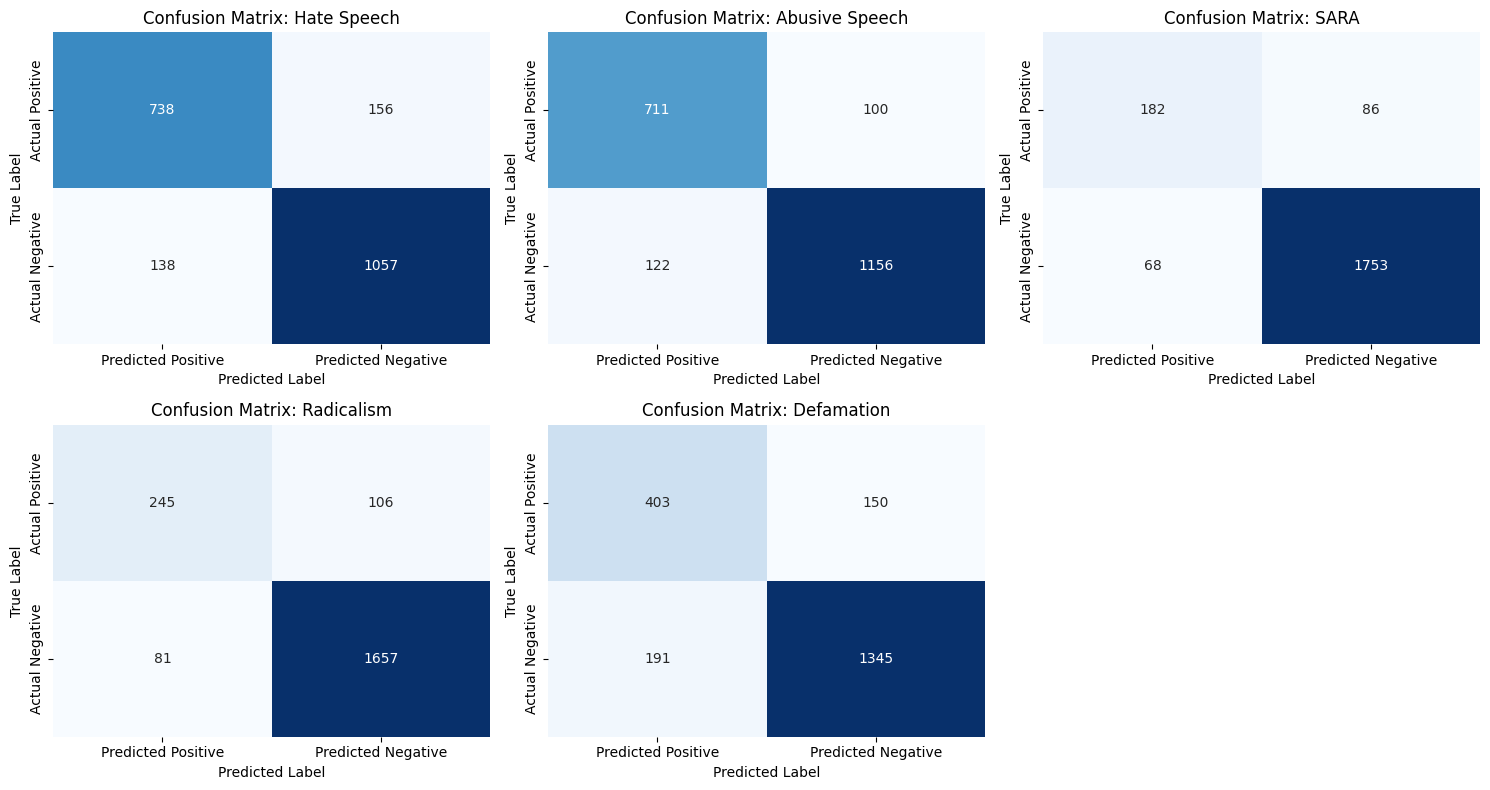

In [100]:
# Compute confusion matrices for each class
conf_matrices = multilabel_confusion_matrix(val_trues, val_binary_preds)

# Plot settings
n_labels = len(category_columns)
cols = 3  # number of plots per row
rows = (n_labels + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, (label, matrix) in enumerate(zip(category_columns, conf_matrices)):
    tn, fp, fn, tp = matrix.ravel()
    cm = [[tp, fp], [fn, tn]]

    df_cm = pd.DataFrame(cm, index=["Actual Positive", "Actual Negative"], columns=["Predicted Positive", "Predicted Negative"])
    
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {label}")
    axes[i].set_ylabel("True Label")
    axes[i].set_xlabel("Predicted Label")

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Tuning

In [79]:
def find_optimal_thresholds(y_true, y_probs, thresholds=np.arange(0.1, 0.9, 0.05)):
    """
    Finds the best threshold for each label to maximize F1-score.
    """
    best_thresholds = []
    
    for i in range(y_true.shape[1]):
        best_f1 = 0
        best_t = 0.5  # default
        for t in thresholds:
            y_pred = (y_probs[:, i] >= t).astype(int)
            score = f1_score(y_true[:, i], y_pred)
            if score > best_f1:
                best_f1 = score
                best_t = t
        best_thresholds.append(best_t)
    return best_thresholds

In [94]:
optimal_thresholds = find_optimal_thresholds(val_trues, val_preds)
print("Optimal thresholds per label:")
for label, t in zip(category_columns, optimal_thresholds):
    print(f"{label}: {t:.2f}")

Optimal thresholds per label:
Hate Speech: 0.25
Abusive Speech: 0.30
SARA: 0.60
Radicalism: 0.50
Defamation: 0.20


In [95]:
def apply_thresholds(y_probs, thresholds):
    """
    Apply per-label thresholds to sigmoid predictions.
    """
    return np.array([(row >= thresholds).astype(int) for row in y_probs])

# Apply thresholds
val_binary_preds = apply_thresholds(val_preds, np.array(optimal_thresholds))

### Evaluation

#### Classification Report

In [ ]:
# Generate classification report
report = classification_report(
    val_trues,
    val_binary_preds,
    target_names=category_columns,
    output_dict=True,
    zero_division=0
)

# Build table rows
headers = ["", "precision", "recall", "f1-score", "support"]
table = []

for label in category_columns:
    row = [
        label,
        f"{report[label]['precision']:.2f}",
        f"{report[label]['recall']:.2f}",
        f"{report[label]['f1-score']:.2f}",
        int(report[label]['support'])
    ]
    table.append(row)

# Add macro & micro averages
macro_avg = report["macro avg"]
micro_avg = report["micro avg"]

table.append([
    "micro avg",
    f"{micro_avg['precision']:.2f}",
    f"{micro_avg['recall']:.2f}",
    f"{micro_avg['f1-score']:.2f}",
    int(micro_avg['support'])
])
table.append([
    "macro avg",
    f"{macro_avg['precision']:.2f}",
    f"{macro_avg['recall']:.2f}",
    f"{macro_avg['f1-score']:.2f}",
    int(macro_avg['support'])
])

In [88]:
print(tabulate(table, headers=headers, tablefmt="fancy_grid"))
# Additional Metrics
print(f"Hamming Loss: {hamming_loss(val_trues, val_binary_preds):.4f}")
print(f"Jaccard Score (samples avg): {jaccard_score(val_trues, val_binary_preds, average='samples', zero_division=0):.4f}")

╒════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│                │   precision │   recall │   f1-score │   support │
╞════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Hate Speech    │        0.79 │     0.88 │       0.84 │       876 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Abusive Speech │        0.85 │     0.89 │       0.87 │       833 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ SARA           │        0.71 │     0.71 │       0.71 │       250 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Radicalism     │        0.7  │     0.75 │       0.72 │       326 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Defamation     │        0.64 │     0.8  │       0.71 │       594 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ micro avg      │        0.76 │     0.84 │       0.8  │      2879 │
├────────────────┼─────────────┼──

#### Confusion Matrix

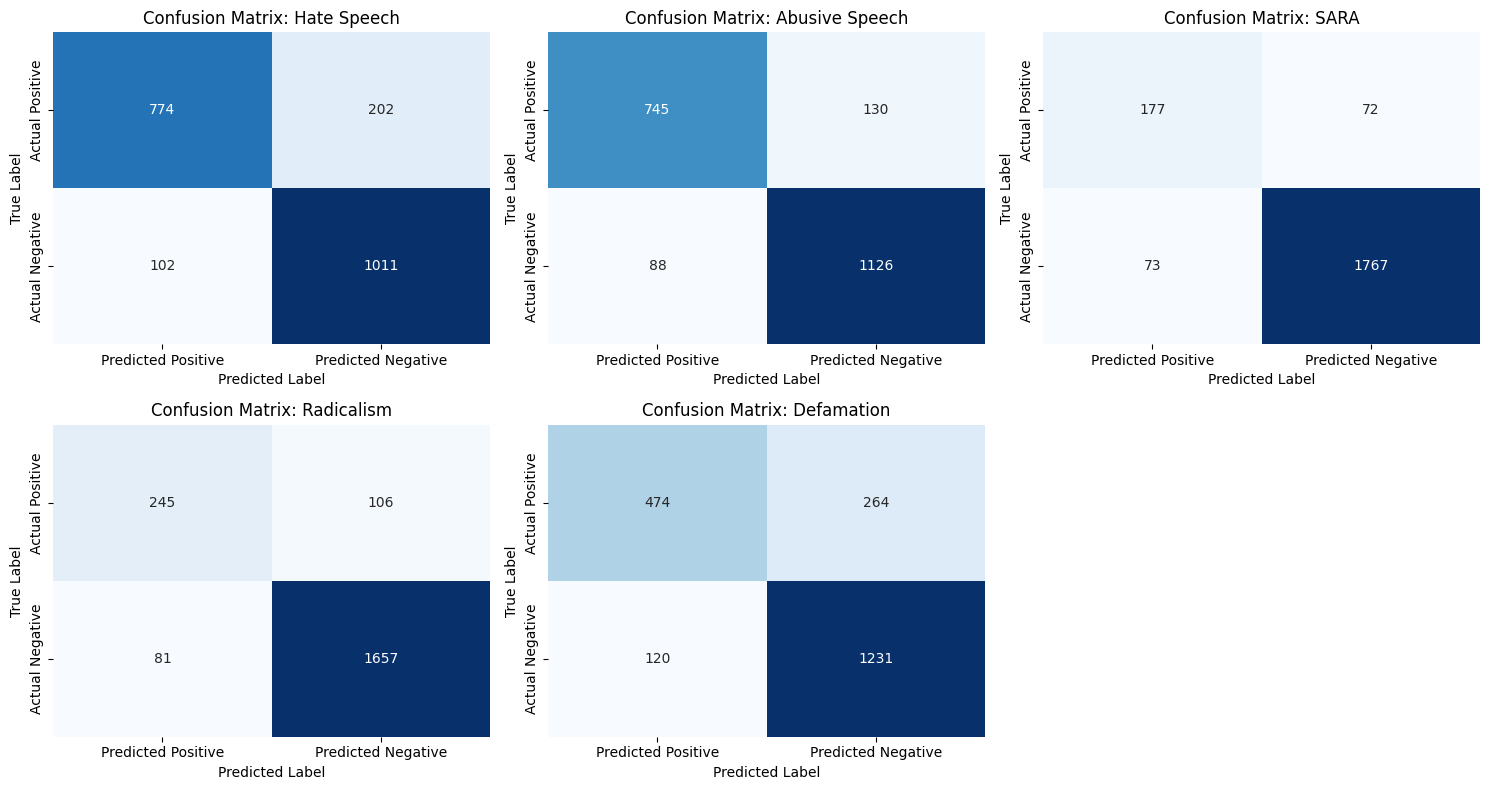

In [96]:
# Compute confusion matrices for each class
conf_matrices = multilabel_confusion_matrix(val_trues, val_binary_preds)

# Plot settings
n_labels = len(category_columns)
cols = 3  # number of plots per row
rows = (n_labels + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, (label, matrix) in enumerate(zip(category_columns, conf_matrices)):
    tn, fp, fn, tp = matrix.ravel()
    cm = [[tp, fp], [fn, tn]]

    df_cm = pd.DataFrame(cm, index=["Actual Positive", "Actual Negative"], columns=["Predicted Positive", "Predicted Negative"])
    
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {label}")
    axes[i].set_ylabel("True Label")
    axes[i].set_xlabel("Predicted Label")

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Testing

## Load

In [3]:
model = torch.load("model-export/model.pth")
tokenizer = BertTokenizer.from_pretrained("model-export")

C:\Users\Radit1812\AppData\Local\Temp\ipykernel_19016\1629377684.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model-export/model.pth")


In [4]:
category_columns = ['Hate Speech', 'Abusive Speech', 'SARA', 'Radicalism', 'Defamation']

In [ ]:
def apply_thresholds(y_probs, thresholds):
    """
    Apply per-label thresholds to sigmoid predictions.
    """
    return np.array([(row >= thresholds).astype(int) for row in y_probs])

In [9]:
def predict(sentences, use_smoothed_threshold=False):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()

    if use_smoothed_threshold:
        binary_preds = apply_thresholds(probs, np.array(optimal_thresholds))  # You must define this
    else:
        binary_preds = (probs >= 0.5).astype(int)

    return binary_preds, probs

In [10]:
test_df = pd.read_csv("data/test.csv")

In [11]:
# Prepare data
texts = test_df["Text"].tolist()
y_true = test_df[category_columns].values

# Predict
y_pred, _ = predict(texts, use_smoothed_threshold=True)

NameError: name 'apply_thresholds' is not defined

## Classification Report

In [17]:
# Generate classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=category_columns,
    output_dict=True,
    zero_division=0
)

# Build table rows
headers = ["", "precision", "recall", "f1-score", "support"]
table = []

for label in category_columns:
    row = [
        label,
        f"{report[label]['precision']:.2f}",
        f"{report[label]['recall']:.2f}",
        f"{report[label]['f1-score']:.2f}",
        int(report[label]['support'])
    ]
    table.append(row)

# Add macro & micro averages
macro_avg = report["macro avg"]
micro_avg = report["micro avg"]

table.append([
    "micro avg",
    f"{micro_avg['precision']:.2f}",
    f"{micro_avg['recall']:.2f}",
    f"{micro_avg['f1-score']:.2f}",
    int(micro_avg['support'])
])
table.append([
    "macro avg",
    f"{macro_avg['precision']:.2f}",
    f"{macro_avg['recall']:.2f}",
    f"{macro_avg['f1-score']:.2f}",
    int(macro_avg['support'])
])

In [18]:
print(tabulate(table, headers=headers, tablefmt="fancy_grid"))
# Additional Metrics
print(f"Hamming Loss: {hamming_loss(y_true, y_pred):.4f}")
print(f"Jaccard Score (samples avg): {jaccard_score(y_true, y_pred, average='samples', zero_division=0):.4f}")

╒════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│                │   precision │   recall │   f1-score │   support │
╞════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Hate Speech    │        0.82 │     0.79 │       0.8  │       877 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Abusive Speech │        0.88 │     0.85 │       0.86 │       834 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ SARA           │        0.66 │     0.66 │       0.66 │       250 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Radicalism     │        0.74 │     0.72 │       0.73 │       326 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Defamation     │        0.74 │     0.68 │       0.71 │       604 │
├────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ micro avg      │        0.8  │     0.76 │       0.78 │      2891 │
├────────────────┼─────────────┼──

## One Sentence

In [12]:
thresholds = {
    'Hate Speech': 0.25,
    'Abusive Speech': 0.30,
    'SARA': 0.60,
    'Radicalism': 0.50,
    'Defamation': 0.20
}

In [ ]:
def predict_labels(text):
    model.eval()
    
    inputs = tokenizer(
        text, padding=True, truncation=True, max_length=128, return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.sigmoid(outputs.logits).squeeze().numpy()

    # Apply category-specific thresholds
    for i, prob in enumerate(probabilities):
        category = category_columns[i]
        if prob >= thresholds[category]:
            print(f"{category}: {prob} (True)")
        else:
            print(f"{category}: {prob} (False)")


In [24]:
custom_sentences = [
    "heh kontol jan sok mes rp muka memek orang tua monyet agama aje agama kontol",
]

# Use either standard or smoothed threshold
predict_labels(custom_sentences)

Hate Speech: 0.9874304533004761 True
Abusive Speech: 0.9940371513366699 True
SARA: 0.011785131879150867 False
Radicalism: 0.006734331138432026 False
Defamation: 0.9910253286361694 True


Optimal thresholds per label:
Hate Speech: 0.25
Abusive Speech: 0.30
SARA: 0.60
Radicalism: 0.50
Defamation: 0.20

## Export Model

In [101]:
output_dir = "./model-export"
torch.save(model, f"{output_dir}/model.pth")
tokenizer.save_pretrained(output_dir)

('./model-export\\tokenizer_config.json',
 './model-export\\special_tokens_map.json',
 './model-export\\vocab.txt',
 './model-export\\added_tokens.json')